In [1]:
import numpy as np
import matplotlib.pyplot as plt

import d3s.domain as domain
import d3s.observables as observables
import d3s.algorithms as algorithms
import d3s.systems as systems
import scipy as _sp
from typing import NewType

# define type
KoopmanMatrix         = NewType("KoopmanMatrix", np.ndarray)
Vector                = NewType("Vector", np.ndarray)
MonomialObservable    = NewType("MonomialObservable", observables.monomials)
Matrix                = NewType("Matrix", np.ndarray)

np.random.seed(seed=233423)
# define domain
#bounds = np.array([[-20, 20], [-20, 20], [-20, 20]])
#boxes = np.array([20, 20, 20])
#Omega = domain.discretization(bounds, boxes)
bounds = np.array([[-2, 2], [-2, 2]])
boxes = np.array([30, 30])
Omega = domain.discretization(bounds, boxes)

# データ生成
#f = systems.Hydrogen(1e-3, 10000)
f = systems.DoubleWell2D(1e-3, 10000)
m = 5000
# generate training data
#X = np.random.randn(2, m)
#r = 20*np.random.rand(m)**(1/3)
#for i in range(m):
#    X[:, i] = r[i]*X[:, i]/np.linalg.norm(X[:, i])
X = Omega.rand(m)
Y = f(X) 

# choose observables
#psi = observables.gaussians(Omega, 0.2)
psi = observables.monomials(10)
#psi = observables.indicators(Omega)

evs = 4 # number of eigenvalues/eigenfunctions to be computed
PsiC = psi(Omega.midpointGrid()) # observables evaluated at midpoints of the grid
print(PsiC.shape)


(66, 900)


In [414]:
print(X[:, :5])

[[ 1.48605129  1.52950391  0.89995454 -1.4136972  -1.90349793]
 [-0.40952905 -1.68587417 -1.50595006 -0.43434722  0.11242586]]


In [4]:
def edmd(X, Y, psi, evs=5, operator='K'):
    '''
    Conventional EDMD for the Koopman or Perron-Frobenius operator. The matrices X and Y
    contain the input data.

    :param psi:      set of basis functions, see d3s.observables
    :param evs:      number of eigenvalues/eigenvectors
    :param operator: 'K' for Koopman or 'P' for Perron-Frobenius
    :return:         eigenvalues d and corresponding eigenvectors V containing the coefficients for the eigenfunctions
    '''
    PsiX = psi(X)
    PsiY = psi(Y)
    C_0 = PsiX @ PsiX.T
    C_1 = PsiY @ PsiX.T
    if operator == 'P': C_1 = C_1.T
    #pesudo-inverse: X.T @ (X @ X.T)^-1
    A = C_1 @ np.linalg.pinv(C_0)
    d, V = sortEig(A, evs)
    return (A, d, V)

def sortEig(A, evs=5, which='LM'):
    '''
    Computes eigenvalues and eigenvectors of A and sorts them in decreasing lexicographic order.

    :param evs: number of eigenvalues/eigenvectors
    :return:    sorted eigenvalues and eigenvectors
    '''
    n = A.shape[0]
    if evs < n:
        #左固有ベクトルを求める
        d, V = _sp.sparse.linalg.eigs(A.T, evs, which=which)
        #V = np.conjugate(V).T
        #d, V = _sp.linalg.eig(A.T, left=True, right=False)
    else:
        d, V = _sp.linalg.eig(A)
    ind = d.argsort()[::-1] # [::-1] reverses the list of indices
    return (d[ind], V[:, ind])

(66, 4)
(66, 900)
(66, 4)
------------------
[-2.26914265e-02-5.57785383e-04j  1.27492202e-01-2.53915850e-02j
  1.36577399e-02-2.74343575e-02j -3.03839060e-02-5.65581473e-02j
 -7.25559438e-03+8.24676472e-02j  1.84561427e-01+1.81555538e-01j
 -4.09270535e-01+8.25419723e-02j  1.88081756e-01+4.08031730e-02j
  1.51186641e-02-2.39407850e-01j -1.01653980e-01+1.99566224e-02j
  1.05013134e-01+5.43817257e-02j  7.62323131e-03-9.04454496e-02j
 -2.66626849e-01+1.40010187e-01j  4.19404500e-03-6.13124047e-02j
 -1.65828028e-01-1.98110394e-01j  3.99428012e-01-4.70081588e-02j
 -1.76911960e-01-3.04804539e-02j -2.50308463e-02+1.00776743e-01j
 -1.46918631e-01-1.62472203e-03j  4.19605645e-02+1.95103567e-01j
  1.04544580e-01-3.73832302e-02j -6.09834025e-02-2.24678369e-02j
 -5.45616406e-02-9.01366432e-03j  1.39404415e-01-1.98314981e-01j
  7.94646461e-02+6.95553215e-02j  1.19073839e-01-2.88393662e-02j
  3.24631288e-02+2.44885181e-02j  7.39995722e-02+7.36958045e-02j
 -1.43069625e-01+6.90006010e-03j  5.63090768e

"\nd, V = algorithms.ulam(X, Y, Omega, operator='P', evs=evs)\nfor i in range(evs):\n    plt.figure()\n    r = np.real(V[:,i])\n    Omega.plot(r, '3D')\n    plt.title('Ulam P, eigenfunction %d' % i)\n\n#%% Ulam's method for Koopman operator\nd, V = algorithms.ulam(X, Y, Omega, operator='K', evs=evs)\nfor i in range(evs):\n    plt.figure()\n    r = np.real(V[:,i])\n    Omega.plot(r, '3D')\n    plt.title('Ulam K, eigenfunction %d' % i)\n"

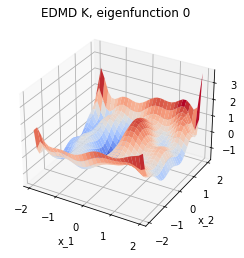

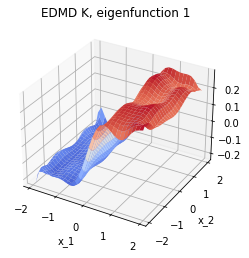

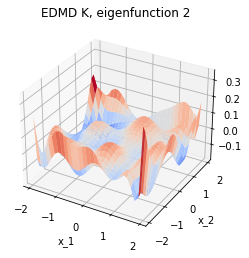

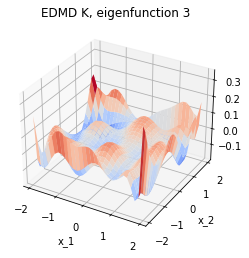

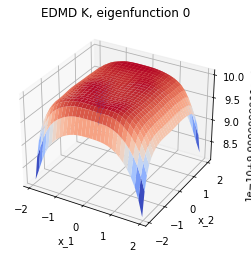

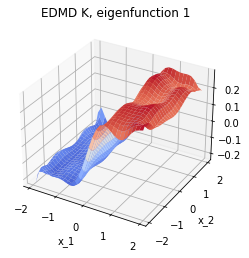

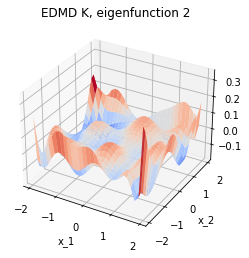

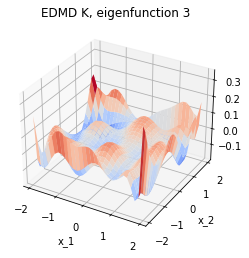

In [8]:
%%time
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#%% create system
"""#%% EDMD for Perron-Frobenius operator
_, d, V = edmd(X, Y, psi, operator='P', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:,i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD P, eigenfunction  %d' % i)
"""
#A_k, d_k, V_k = edmd(X, Y, psi, operator='K', evs=evs)
#for i in range(0,10):
#    fig = plt.figure(2)
#    plt.clf()
#    ax = fig.add_subplot(111, projection='3d')
#    w = V_k[:, i]/np.amax(abs(V_k[:, i]))
#   ind, = np.where(abs(w) > 0.1)
#   ax.scatter(X[0, ind], X[1, ind], X[2, ind], c=w[ind])
#    plt.title('E_%i = %f' % (i, np.real(d[i])))
#    plt.pause(1)

#%% EDMD for Koopman operator    
A_k, d_k, V_k = edmd(X, Y, psi, operator='K', evs=evs)
V_k = -1*V_k
print(V_k.shape)
print(PsiC.shape)
for i in range(evs):
    plt.figure()
    r = np.real(V_k[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)

A, d, V = algorithms.edmd(X, Y, psi, operator='K', evs=evs)
print(V.shape)
for i in range(evs):
    plt.figure()
    r = np.real(V[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)

print("------------------")
#print(A_k[:5, :5].T)
#print(A[:5, :5])
#print(np.max(A-A_k.T))
print(V_k[:, 2])
print("------------------")
print(V[:, 2])
print(np.max(np.abs(V)-np.abs(V_k)))
print("------------------")

#%% Ulam's method for Perron-Frobenius operator
'''
d, V = algorithms.ulam(X, Y, Omega, operator='P', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:,i])
    Omega.plot(r, '3D')
    plt.title('Ulam P, eigenfunction %d' % i)

#%% Ulam's method for Koopman operator
d, V = algorithms.ulam(X, Y, Omega, operator='K', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:,i])
    Omega.plot(r, '3D')
    plt.title('Ulam K, eigenfunction %d' % i)
'''

CPU times: user 14.8 s, sys: 587 ms, total: 15.4 s
Wall time: 3.26 s


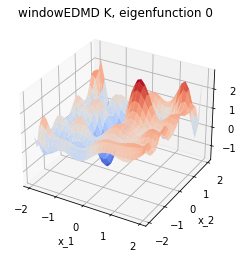

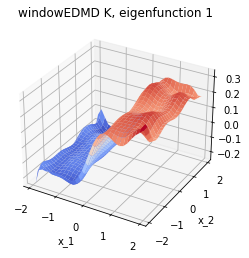

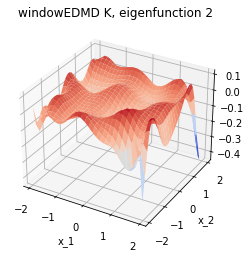

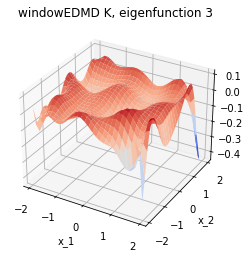

In [51]:
%%time

#apply windowed rEDMD

#%% define window_update
def window_update(A_M: KoopmanMatrix, P_M: Matrix, U: Matrix, V: Matrix, C_inv: Matrix) -> Vector:
    G_M = np.linalg.inv(C_inv + U.T @ P_M @ U)
    A_M = A_M + (V - A_M @ U) @ G_M @ U.T @ P_M
    Z = (V - A_M @ U) @ G_M @ U.T @ P_M
    P_M = P_M - P_M @ U @ G_M @ U.T @ P_M
    return (A_M, P_M)

#%% set data
w = 4000
X_base = X[:, :w]
Y_base = Y[:, :w]

C_inv = np.linalg.inv(np.array([[-1, 0],[0, 1]]))

#koopman operator
A_M, d, V = edmd(X_base, Y_base, psi, operator='K', evs=evs)
P_M = np.linalg.pinv(psi(X_base) @ psi(X_base).T)
PsiX = psi(X)
PsiY = psi(Y)
for i in range(m-w):
    U = np.array([PsiX[:, i], PsiX[:, w+i]]).T
    V = np.array([PsiY[:, i], PsiY[:, w+i]]).T
    A_M, P_M = window_update(A_M, P_M, U, V, C_inv)
d_K, V = sortEig(A_M, evs)
#d,V = np.linalg.eig(A_M)
for i in range(evs):
    plt.figure()
    r = np.real(V[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('windowEDMD K, eigenfunction %d' % i)

In [43]:
'''   
#perron-frobenius
A_M, d, V = algorithms.edmd(X_base, Y_base, psi, operator='P', evs=evs)
P_M = np.linalg.pinv(psi(X_base) @ psi(X_base).T)
for i in range(m-init_size):    
    A_M, P_M = window_update(A_M, P_M, X_base[:, i], Y_base[:, i], X_add[:, i], Y_add[:, i], psi, C)
    
d_K,V = algorithms.sortEig(A_M, evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:,i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)
'''

"   \n#perron-frobenius\nA_M, d, V = algorithms.edmd(X_base, Y_base, psi, operator='P', evs=evs)\nP_M = np.linalg.pinv(psi(X_base) @ psi(X_base).T)\nfor i in range(m-init_size):    \n    A_M, P_M = window_update(A_M, P_M, X_base[:, i], Y_base[:, i], X_add[:, i], Y_add[:, i], psi, C)\n    \nd_K,V = algorithms.sortEig(A_M, evs)\nfor i in range(evs):\n    plt.figure()\n    r = np.real(V[:,i].T @ PsiC)\n    Omega.plot(r, '3D')\n    plt.title('EDMD K, eigenfunction %d' % i)\n"

(66, 900)
CPU times: user 30.5 s, sys: 395 ms, total: 30.9 s
Wall time: 5.93 s


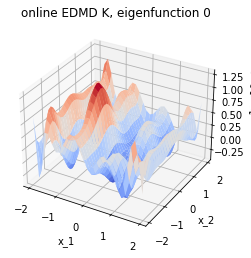

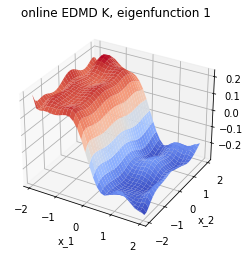

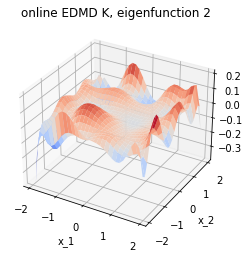

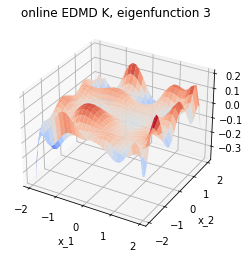

In [50]:
%%time
#rEDMD not window

init_size = 3000
X_base = X[:, :init_size]
Y_base = Y[:, :init_size]
G = np.linalg.pinv(psi(X_base) @ psi(X_base).T)
K, d, V = edmd(X_base, Y_base, psi, operator='K', evs=evs)
def online_EDMD(K: KoopmanMatrix, G: Matrix, X: Vector, Y: Vector) -> Vector:
    gamma = 1/(1+(X.T @ G @ X))
    K = K + gamma*(Y - K @ X) @ X.T @ G
    G = G - gamma* G @ X @ X.T @ G 
    return K, G
PsiX = psi(X)
PsiY = psi(Y)
for i in range(m-init_size):
    X_add = PsiX[:, init_size+i].reshape(-1,1)
    Y_add = PsiY[:, init_size+i].reshape(-1,1)
    K, G = online_EDMD(K, G, X_add, Y_add)
d_K, V = sortEig(K, evs)
print(PsiC.shape)
#d,V = np.linalg.eig(A_M)
for i in range(evs):
    plt.figure()
    r = np.real(V[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('online EDMD K, eigenfunction %d' % i)

In [26]:
print(np.max(pG-iG))

3.1486708206018843e-10


Online DMD, weighting = 1, time = 1.174678087234497 secs


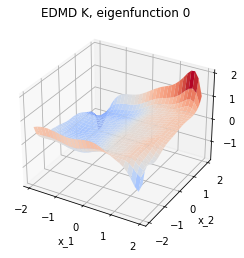

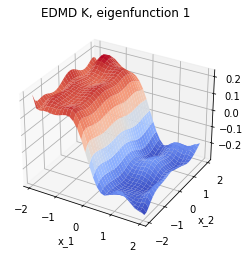

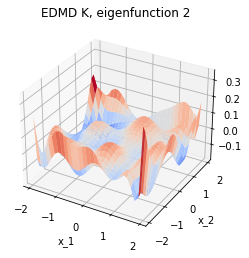

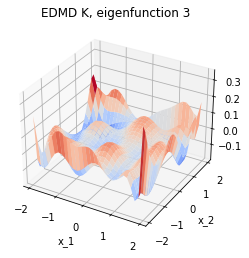

In [53]:
# Online DMD, weighting = 1
from odmd import OnlineDMD
import time
q = 2000
dt = 0.1
PsiX = psi(X)
PsiY = psi(Y)
n, m = len(PsiX[:, 0]), len(PsiY[0, :])
evalsonlineDMD1 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 1)
odmd.initialize(PsiX[:, :q], PsiY[:, :q])
start = time.time()
for k in range(q, m):
    odmd.update(PsiX[:, k], PsiY[:, k])
    evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")
d, V = sortEig(odmd.A, evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)

Window DMD, w=10, weighting = 1, time = 0.8172681331634521 secs


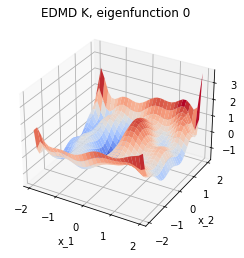

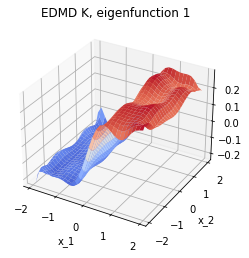

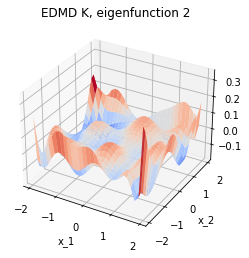

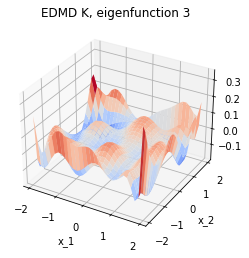

In [47]:
from odmd import WindowDMD
w = 3000
evalswindowDMD2 = np.empty((n, m), dtype=complex)
wdmd = WindowDMD(n, w, 1)
wdmd.initialize(PsiX[:, :w], PsiY[:, :w])
start = time.time()
for k in range(w, m):
    wdmd.update(PsiX[:, k], PsiY[:, k])
    evalswindowDMD2[:, k] = np.log(np.linalg.eigvals(wdmd.A))/dt
end = time.time()
print("Window DMD, w=10, weighting = 1, time = " + str(end-start) + " secs")
A_wodmd = wdmd.A
d, V = sortEig(A_wodmd, evs)
for i in range(evs):
    plt.figure()
    r = np.real(V_k[:,i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)